# Projet IF29 P22
### Détection des influenceurs sur Twitter en appliquant les méthodes non supervisée et supervisée

In [1]:
# Créer la BD en utilisant le fichier 'Worldcup 200Tweets' sur moodle
from pymongo import MongoClient

In [ ]:
import os
import json

client = MongoClient('localhost', 27017)
db = client['______'] # nom de BD
collection = db['______'] #nom de collection
parent_dir = ("_____________________________________") #adresse de fichier
list_filename = os.listdir(parent_dir)

for filename in list_filename:
    filepath = parent_dir + filename
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()
        f.close()
    for line in lines:
        document = json.loads(line[:-1])
        collection.insert_one(document)

In [2]:
# Connecter à la BD
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['if29']
collection = db['Tweet Worldcup 200']

In [3]:
# Créer le dataframe en utilisant les attributs qui nous intéressent concernant les utilisateurs
import numpy as np
import pandas as pd

cursor = collection.aggregate(
    [
        {"$group" : {
            "_id" : "$user.id", 
            "friends_count" : {"$last" : "$user.friends_count"},
            "favourites_count" : {"$last" : "$user.favourites_count"},
            "statuses_count" : {"$last" : "$user.statuses_count"},
            "followers_count" : {"$last" : "$user.followers_count"},
             "created_time" : {"$last" : "$user.created_at"}
        }
        }
    ]
)
df = pd.json_normalize(cursor)

In [7]:
# Première analyse sur le résumé des données quantitatives
df.iloc[:,[1,2,3,4]].describe().astype(int)

,friends_count,favourites_count,statuses_count,followers_count
count,267467,267467,267467,267467
mean,1101,9108,22204,7829
std,5539,25271,54745,181738
min,0,0,1,0
25%,186,380,1329,124
50%,408,1946,6275,363
75%,906,7547,21751,1019
max,544830,1718515,8898917,30755372


In [5]:
# Calculer les indicateurs (attributs dérivés) ci-dessous destinés à la description des 'influenceurs'
# 1) Visibilité: Vis
# 2) Nombre moyen de 'aimer' par tweet: avg_fav 
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency

In [4]:
# 1) Visibilité: Vis

# Regrouper les textes de tweet par chaque utilisateur
cursor1 = collection.aggregate(
    [        
         {"$group" : {
            "_id" : "$user.id", 
            
            "tweets" : {"$push": "$text"}
        }
        }
    ]
)
df1 = pd.json_normalize(cursor1)

In [5]:
def calcul_visibility(row):
    s = 0
    for tweet in row["tweets"]:
        s += tweet.count("@")*11.4  # le coût moyen pour @ est 11,4
        s += tweet.count("#")*11.6  # le coût moyen pour # est 11,6 cf.fichier 'SPOT'
    return s/(140*len(row["tweets"]))

visibilities = df1.apply(calcul_visibility,axis=1)

In [6]:
# 2) Nombre moyen de 'aimer' par tweet: avg_fav
avg_fav = df.favourites_count/df.statuses_count

In [7]:
# 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
r_fri_follow = df.followers_count/df.friends_count

In [8]:
# 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency
import time
def ratio(row):
    time_array = time.strptime(row["created_time"], "%a %b %d %H:%M:%S +0000 %Y")
    time_stamp = time.mktime(time_array)
    time_stamp_0 = time.mktime(time.strptime("Mon Jan 1 00:00:00 2019", '%a %b %d %H:%M:%S %Y'))
    # on multiplie une constante = 100 pour amplifier les résultats
    return row["statuses_count"]*100/(time_stamp_0 - time_stamp) 

frequency = df.apply(ratio, axis=1)  

In [9]:
# Générer un dataframe en regroupant les quatres indicateurs calculés
features = pd.DataFrame()
features["user_id"] = df.iloc[:,0]
features["vis"] = visibilities
features["r_fri_follow"] = r_fri_follow
features["avg_fav"] = avg_fav
features["frequency"] = frequency

In [10]:
# On supprime toutes les lignes qui contiennent 'Nan' ou 'inf'

pd.options.mode.use_inf_as_na = True
features.dropna(inplace=True)
features = features.reset_index(drop=True)

In [11]:
# On normalise les données pour effectuer les classifications
from sklearn import preprocessing

features_normalized = preprocessing.normalize(features.iloc[:,[1,2,3,4]])
features_normalized = pd.DataFrame(features_normalized)
features_normalized.columns = ['vis','r_fri_follow','avg_fav','frequency']
features_normalized

,vis,r_fri_follow,avg_fav,frequency
0,0.381866,0.898508,0.216474,0.000415
1,0.101709,0.981106,0.164564,0.002048
2,0.606955,0.737448,0.284453,0.082846
3,0.079199,0.812380,0.577698,0.005604
4,0.137039,0.103644,0.985103,0.007079
...,...,...,...,...
266198,0.167861,0.046284,0.984723,0.000372
266199,0.596537,0.296487,0.745800,0.004563
266200,0.079234,0.996339,0.016786,0.027369
266201,0.263362,0.869427,0.417946,0.007646


In [25]:
# On effectue l'ACP pour réduire les 4 dimensions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=4, suppress=False)

features_standardized = StandardScaler().fit_transform(features.iloc[:,[1,2,3,4]]) #il faut centrer et réduire les données d'abord
# vérification
print("La moyenne : \n",np.mean(features_standardized,axis=0))
print("\n")
print("L'écart type: \n",np.std(features_standardized,axis=0))

La moyenne : 
 [2.0174e-16 8.6081e-19 1.3132e-17 1.0431e-16]


L'écart type: 
 [1. 1. 1. 1.]


In [41]:
acp = PCA(svd_solver='auto')
coord = acp.fit_transform(features_standardized) 
print("Explained variance ratio:\n", acp.explained_variance_ratio_) # les pourcentage de variance projectée sur chaque axe (composante principale)
coord # les coordonées des individus dans les nouveaux repères

Explained variance ratio:
 [0.2578 0.2501 0.2497 0.2424]


array([[-0.245 , -0.2152,  0.0946,  0.318 ],
       [-0.2547, -0.223 ,  0.0898,  0.3416],
       [ 0.344 ,  1.0878, -0.7761, -0.4473],
       ...,
       [-0.2024, -0.2211,  0.084 ,  0.2944],
       [-0.153 , -1.0999,  0.6788,  0.3478],
       [-0.0973, -0.6597,  0.3737,  0.2488]])

In [30]:
# Basé sur le résultat d'ACP, on effectue le K-means dans le plan (1,2) qui se compose de deux composantes dont inerties les plus élevées 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0) # Selon le sujet, ici on ne choisit que de classer en 2 clusters.
labels = kmeans.fit_predict(coord[:,[0,1]])   # on ne prend que les coordonées de l'axe 1 et 2

print(np.unique(labels, return_counts=True)) # afficher la condition de séparation

labels0 = coord[labels == 0]
labels1 = coord[labels == 1]

Training time: 0.647268533706665s
(array([0, 1]), array([206307,  59896], dtype=int64))


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

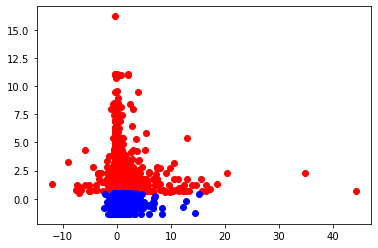

In [41]:
plt.scatter(np.random.choice(labels0[:,0],10000), np.random.choice(labels0[:,1],10000), c='red') # Pour voir plus clairement, on prend aléatoirement 100 points pour tracer le graphique
plt.scatter(np.random.choice(labels1[:,0],10000), np.random.choice(labels1[:,1],10000), c='blue') 

In [15]:
# Avant de passer à l'approche supervisée, il faut d'abord labeliser les données
# Dans cette étape on va utiliser un échantillon de taille 50000 pour entraîner le modèle
# Comme on a 4 indicateurs, on décide de les combiner en utilisant la méthode d'entropie

In [12]:
# Méthode d'entropie

data = features.iloc[:,[1,2,3,4]]
indicateur = data.columns.tolist()   ## nombre des indicateurs
profil = data.index.tolist()    ## nombre des profils
value = data.values

# définir la fonction de normalisation, on rajoute une constante 0,01
def std_data(value,flag):
    for i in range(len(indicateur)):
        if flag[i]=='+':
            value[:,i]=(value[:,i]-np.min(value[:,i],axis=0))/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
        elif flag[i]=='-':
            value[:,i]=(np.max(value[:,i],axis=0)-value[:,i])/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
    return value

# définir la fonction d'entropie et calculer les poids et les entropies
def cal_weight(indicateur,profil,value):
    p= np.array([[0.0 for i in range(len(indicateur))] for i in range(len(profil))])                    
    for i in range(len(indicateur)):
        p[:,i]=value[:,i]/np.sum(value[:,i],axis=0)
        
    e=-1/np.log(len(profil))*sum(p*np.log(p))      #calcul d'entropie
    g=1-e     
    w=g/sum(g)     #calcul des poids
    return w

# normalisation des données
flag=["+","+","+","+"]  ## '+' ou '-' désigne le sens positif ou négatif des indicateurs
std_value=std_data(value,flag)
std_value.round(3)

# Résultat
w=cal_weight(indicateur,profil,std_value)
w=pd.DataFrame(w,index=data.columns,columns=['Poids'])
print("#######Poids:#######")
print(w)
score=np.dot(std_value,w).round(2)
score=pd.DataFrame(score,index=data.index,columns=['Notes']).sort_values(by =['Notes'],ascending = False)

# la note de chaque utilisateur représente la correspondance avec les profils qu'on va détecter
# Si une note plus élevée, le profil correspondant est plus probablement censé un influnceur

#######Poids:#######
                 Poids
vis           0.528232
r_fri_follow  0.009409
avg_fav       0.030446
frequency     0.431914


In [17]:
# A l'aide de résultat ci-dessus, on peut compter la fréquence de chaque note. Avec cela, on va ensuite calculer
# le pourcentage de fréquence cumulée. En vertu de principe de Pareto (80/20), on peut alors découper les données en 2 classes:
# les profils plus générals (la somme de fréquence représente environ 80% au total) et le reste plus critique (20%)

In [13]:
import collections
data1 = []
for i in range(266203):
    data1.append(score.iloc[i,0])

c = collections.Counter(data1) #créer un counter pour compter la fréquence de note

freq = np.array(list(dict(c).items()),dtype = 'float')

freq = freq[np.lexsort(-freq.T)] # ordonner par décroissant en fonction de fréquence

somme = 0
cumul = 0.00
cluster = []

for i in range(len(data)):
    if cumul <= 0.81:          # 0.01 de tolérance 
        somme = somme + freq[i,1].astype(int)
        cluster.append(freq[i,0])
        cumul = somme/len(score)
    else: break
    
print(cumul) # le pourcentage cumulé pour la classe 'générale'
print(cluster) #les notes de cette classe

0.8133717501305395
[0.05, 0.03, 0.07, 0.09, 0.01, 0.06, 0.04]


In [37]:
# On va maintenant labeliser les profils en fonction de classes divisées ci-dessus
label = score.apply(lambda row: 0 if row["Notes"] in cluster else 1, axis=1 )
label

85307     1
141753    1
228955    1
90331     1
61573     1
         ..
8084      0
14252     0
175296    0
14250     0
159901    0
Length: 266203, dtype: int64

In [38]:
# Application de la méthode SVM
data = features_normalized
data["label"] = label
data = data.sample(50000) # On prend un échantillon de taille 50000

X = data.iloc[:,[0,1,2,3]]
Y = data.iloc[:,[4]]
X = X.to_numpy()
Y = Y.to_numpy().ravel()

In [49]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                    test_size=0.3, random_state=42) # On sépare les jeux d'entrâinement et de test         


# parameters = {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.001,0.0001]}

start = time.time()
svm_clf = svm.SVC(C=100, gamma=10, class_weight='balanced')
svm_clf.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

             
# svm_clf = svm.SVC()


# clf = GridSearchCV(svm_clf, parameters)
# clf.fit(X_train, y_train)

# a=pd.DataFrame(clf.cv_results_)
# a.sort_values(['mean_test_score'],ascending=False)


# print(clf.best_estimator_, clf.best_score_)

Training time: 126.71596574783325s


In [50]:
y_pred = svm_clf.predict(X_test)
print(accuracy_score(y_test,y_pred),'\n',classification_report(y_test,y_pred))

0.7248666666666667 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82     12291
           1       0.35      0.62      0.45      2709

    accuracy                           0.72     15000
   macro avg       0.63      0.68      0.63     15000
weighted avg       0.80      0.72      0.75     15000



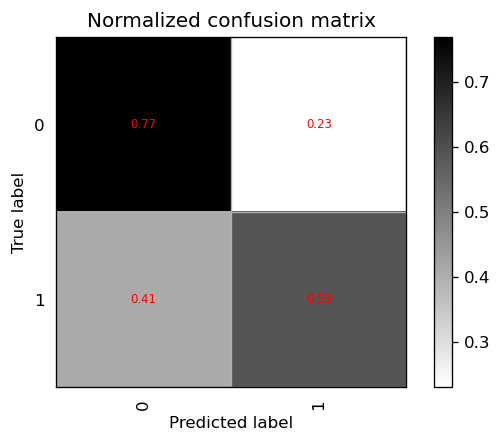

In [41]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm_normalized)

tick_marks = np.array(range(2)) + 0.5###

labels=range(2)###
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(2))###
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(6, 4), dpi=120)

ind_array = np.arange(2)###
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
# plt.savefig('C:/Users/Sun/Desktop/curves/3_class/dnn/cm.png')
plt.show()

In [30]:
#ROC cureve
from sklearn import metrics
from sklearn.metrics import auc

In [51]:
y_score = svm_clf.decision_function(X_test)

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

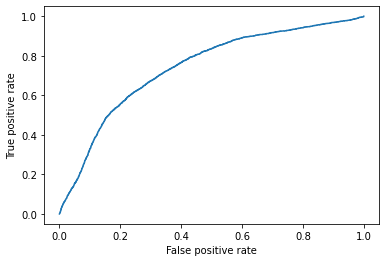

In [62]:
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [61]:
AUC = auc(fpr, tpr)
print("AUC: ",AUC)

AUC:  0.7399783441526975


In [55]:
#learing curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    svm_clf, X_train, y_train, scoring='accuracy'
)

In [58]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

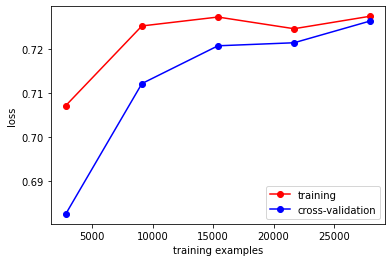

In [60]:
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='cross-validation')
plt.xlabel("training examples")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()